In [1]:
!nvidia-smi

Fri Jul  2 18:38:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Load custom package from Github**



In [2]:
!git clone https://github.com/Gilf641/torchly

from google.colab import files
import sys
import os
os.chdir('torchly')
ROOT_DIR = '/content'
# /content/torchly
# To find local version of the library
sys.path.append(os.path.join(ROOT_DIR, 'torchly'))  


Cloning into 'torchly'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 109 (delta 36), reused 100 (delta 27), pack-reused 0
Receiving objects: 100% (109/109), 95.01 KiB | 11.88 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive')

%reload_ext tensorboard


Mounted at /content/gdrive


In [4]:
!pip install -U albumentations>=0.3.0 --user
!pip install --upgrade git+https://github.com/albumentations-team/albumentations


import albumentations as A

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-7u20ij_4
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-7u20ij_4
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98531 sha256=e5b0aff11073b65cc9dd222823fa73da651b468d79411086331621c25bd5ba21
  Stored in directory: /tmp/pip-ephem-wheel-cache-wnk8u98p/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


**Load required packages**

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict

# custom torch package
import torchly
from torchly.run import train, test, fit
from torchly.data.gradcam import generate_gcam, unnormalize, plot_gcam 
from torchly.data.dataloader import convert
from torchly.data.dataset import CIFAR_Dataset
from torchly.utils import data_utils, model_utils
# from torchly.models.cifar_net import Net2
from torchly.models.resnet import ResNet18
from torchly.torchsummary import summary
from torchly.run.runner2 import run, get_class_accuracy


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
# Download CIFAR data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Train and Test Transforms**


In [7]:

train_transform = A.Compose(
    [
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        A.RandomCrop(height=32, width=32, p=0.5),
        # A.Cutout(),
        A.Rotate(limit=(-5,5)),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4675, 0.4599, 0.4236), mask_fill_value = None),
        ToTensorV2(),
    ])


test_transform = A.Compose(
    [
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])

In [8]:
train = CIFAR_Dataset(trainset.data, trainset.targets, transforms=train_transform)
test = CIFAR_Dataset(testset.data, testset.targets, transforms=test_transform)

train_loader, test_loader = convert(train, test)


**Setting up Config**

In [9]:
class GlobalConfig:
    seed = 1992
    num_classes = 10
    batch_size = 128
    EPOCHS = 40
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data
    input_image_size = (3, 32, 32)
    mean = (0.4675, 0.4599, 0.4236)
    std_dev = (0.2901, 0.2874, 0.2917)
    trainloader = train_loader
    testloader = test_loader

    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



    # model data normalization
    channel_norm = 'GroupNorm'
    channel_norm_params = {'GroupNorm': {'num_groups':1}, # doing layernorm here
                 'BatchNorm2d':{'affine':True}}
                #  'LayerNorm': {'normalized_shape':10}}
                

    # regularizer
    dropout_value = 0.05

    # loss
    # loss_function = 'CrossEntropyLoss'
    loss_function = 'NLLoss'

    # scheduler
    lr_scheduler = 'OneCycleLR'
    lr_scheduler_params = {'StepLR': {'step_size':7, 'gamma':0.5},
                
                'ReduceLROnPlateau': {'mode':'min', 'factor':0.5, 'patience':2, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-4,
                                      'eps':1e-08, 'verbose':True},
                'OneCycleLR': {'max_lr': 0.2, 'steps_per_epoch':len(trainloader), 'div_factor':20, 'epochs':EPOCHS }}
                                

    # optimizer
    optimizer = 'SGD'
    optimizer_params = {'SGD':{'lr':0.01, 'momentum':0.9}}

    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}

    # Params
    misclassified=True
    L1Lambda=False

    # ModelName
    name='168K_100Epochs'

    
modelconfig = GlobalConfig


Let us show some of the training images, for fun.



**Data Visualization**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

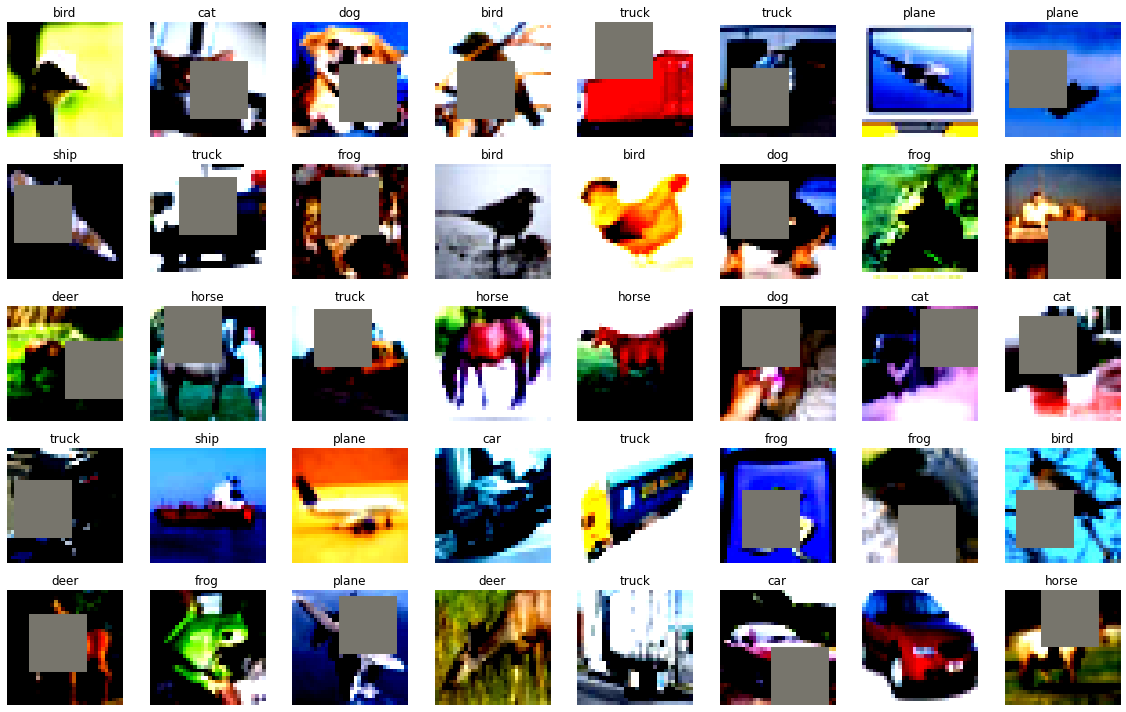

In [10]:
img, label = next(iter(modelconfig.trainloader))
data = CIFAR_Dataset(img,label)
data_utils.plot_data(data,modelconfig)

All classes have same number of images, 5000. Dataset is balanced. 

**Model Summary**

In [11]:
model = ResNet18(modelconfig).to(modelconfig.device)
summary(model, (3,32,32))

------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape         Param #           Receptive Field
            Conv2d-1           [-1, 64, 32, 32]           1,728               3
         GroupNorm-2           [-1, 64, 32, 32]             128               3
            Conv2d-3           [-1, 64, 32, 32]          36,864               5
         GroupNorm-4           [-1, 64, 32, 32]             128               5
            Conv2d-5           [-1, 64, 32, 32]          36,864               7
         GroupNorm-6           [-1, 64, 32, 32]             128               7
        BasicBlock-7           [-1, 64, 32, 32]               0               7
            Conv2d-8           [-1, 64, 32, 32]          36,864               9
         GroupNorm-9           [-1, 64, 32, 32]             128               9
           Conv2d-10           [-1, 64, 32, 32]          36,864              11
        Group

(tensor(2777674), tensor(2777674))

**Run the model**

In [12]:

model =  ResNet18(modelconfig).to(modelconfig.device)
result_dict, test_misc_images = run(model, modelconfig)

  0%|          | 0/391 [00:00<?, ?it/s]

==========RUNNING THE MODEL==========
EPOCH 1 | LR [0.008000000000000007]: 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Train set: Loss=1.7317193746566772 Batch_id=390 Accuracy=33.71: 100%|██████████| 391/391 [00:48<00:00,  8.07it/s]



Test set: Loss: 1.7662, Accuracy: 3613/10000 (36.13%)



/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 2 | LR [0.011272507482793986]: 


Train set: Loss=1.0983703136444092 Batch_id=390 Accuracy=49.01: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s]



Test set: Loss: 1.3854, Accuracy: 5029/10000 (50.29%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 3 | LR [0.020866919405656298]: 


Train set: Loss=1.2618639469146729 Batch_id=390 Accuracy=56.41: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s]



Test set: Loss: 1.3142, Accuracy: 5523/10000 (55.23%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 4 | LR [0.03612911525169993]: 


Train set: Loss=1.169570803642273 Batch_id=390 Accuracy=61.54: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 1.1026, Accuracy: 5992/10000 (59.92%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 5 | LR [0.05601856064363234]: 


Train set: Loss=1.1326266527175903 Batch_id=390 Accuracy=64.92: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]



Test set: Loss: 1.3074, Accuracy: 5770/10000 (57.70%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 6 | LR [0.0791792481049176]: 


Train set: Loss=0.980989933013916 Batch_id=390 Accuracy=67.30: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Loss: 0.9546, Accuracy: 6724/10000 (67.24%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 7 | LR [0.10403214590589517]: 


Train set: Loss=0.7137799263000488 Batch_id=390 Accuracy=69.22: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Loss: 0.9677, Accuracy: 6692/10000 (66.92%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 8 | LR [0.12888285208775643]: 


Train set: Loss=0.6902486681938171 Batch_id=390 Accuracy=71.12: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 1.2039, Accuracy: 6206/10000 (62.06%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 9 | LR [0.15203711411023357]: 


Train set: Loss=0.6911641955375671 Batch_id=390 Accuracy=72.93: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]



Test set: Loss: 0.8385, Accuracy: 7165/10000 (71.65%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 10 | LR [0.17191633831234468]: 


Train set: Loss=0.7000660300254822 Batch_id=390 Accuracy=74.57: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]



Test set: Loss: 0.8827, Accuracy: 7043/10000 (70.43%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 11 | LR [0.18716521407005757]: 


Train set: Loss=0.5688978433609009 Batch_id=390 Accuracy=75.60: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Loss: 0.6795, Accuracy: 7698/10000 (76.98%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 12 | LR [0.19674411513292825]: 


Train set: Loss=0.6385024785995483 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Loss: 0.6298, Accuracy: 7836/10000 (78.36%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 13 | LR [0.1999999958828335]: 


Train set: Loss=0.4435875415802002 Batch_id=390 Accuracy=78.05: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.5666, Accuracy: 8026/10000 (80.26%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 14 | LR [0.19936800653990835]: 


Train set: Loss=0.7368730306625366 Batch_id=390 Accuracy=78.82: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.7109, Accuracy: 7643/10000 (76.43%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 15 | LR [0.1974864118903156]: 


Train set: Loss=0.48595982789993286 Batch_id=390 Accuracy=79.95: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.5444, Accuracy: 8137/10000 (81.37%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 16 | LR [0.19437887407850052]: 


Train set: Loss=0.4490063786506653 Batch_id=390 Accuracy=80.67: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Loss: 0.6753, Accuracy: 7743/10000 (77.43%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 17 | LR [0.19008447219548213]: 


Train set: Loss=0.477783739566803 Batch_id=390 Accuracy=81.51: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]



Test set: Loss: 0.5855, Accuracy: 8019/10000 (80.19%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 18 | LR [0.1846572108366094]: 


Train set: Loss=0.5453858971595764 Batch_id=390 Accuracy=82.13: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Loss: 0.7269, Accuracy: 7708/10000 (77.08%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 19 | LR [0.17816534096244052]: 


Train set: Loss=0.38926833868026733 Batch_id=390 Accuracy=82.66: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]



Test set: Loss: 0.5646, Accuracy: 8139/10000 (81.39%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 20 | LR [0.17069050160331384]: 


Train set: Loss=0.37374788522720337 Batch_id=390 Accuracy=82.90: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Loss: 0.5262, Accuracy: 8209/10000 (82.09%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 21 | LR [0.16232669320117316]: 


Train set: Loss=0.5702470541000366 Batch_id=390 Accuracy=83.81: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.5281, Accuracy: 8208/10000 (82.08%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 22 | LR [0.1531790954994701]: 


Train set: Loss=0.459096759557724 Batch_id=390 Accuracy=84.61: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.4960, Accuracy: 8364/10000 (83.64%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 23 | LR [0.14336274484686334]: 


Train set: Loss=0.2354407012462616 Batch_id=390 Accuracy=84.69: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Loss: 0.5273, Accuracy: 8305/10000 (83.05%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 24 | LR [0.13300108754838877]: 


Train set: Loss=0.2784422039985657 Batch_id=390 Accuracy=85.54: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]



Test set: Loss: 0.5271, Accuracy: 8290/10000 (82.90%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 25 | LR [0.12222442745654832]: 


Train set: Loss=0.45994800329208374 Batch_id=390 Accuracy=85.89: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Loss: 0.6691, Accuracy: 7918/10000 (79.18%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 26 | LR [0.11116828732476068]: 


Train set: Loss=0.2913810610771179 Batch_id=390 Accuracy=86.28: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Loss: 0.5428, Accuracy: 8235/10000 (82.35%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 27 | LR [0.09997170453010501]: 


Train set: Loss=0.2903428375720978 Batch_id=390 Accuracy=86.99: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Loss: 0.4905, Accuracy: 8466/10000 (84.66%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 28 | LR [0.08877548259763278]: 


Train set: Loss=0.30964043736457825 Batch_id=390 Accuracy=87.08: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s]



Test set: Loss: 0.4605, Accuracy: 8490/10000 (84.90%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 29 | LR [0.07772042051434407]: 


Train set: Loss=0.4404020309448242 Batch_id=390 Accuracy=87.69: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.5304, Accuracy: 8300/10000 (83.00%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 30 | LR [0.06694554210023271]: 


Train set: Loss=0.39634448289871216 Batch_id=390 Accuracy=87.91: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe



Test set: Loss: 0.5033, Accuracy: 8378/10000 (83.78%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 31 | LR [0.05658634770308624]: 


Train set: Loss=0.2081363946199417 Batch_id=390 Accuracy=88.67: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.5062, Accuracy: 8438/10000 (84.38%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 32 | LR [0.046773110202993295]: 


Train set: Loss=0.1710958182811737 Batch_id=390 Accuracy=88.82: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s]



Test set: Loss: 0.5050, Accuracy: 8377/10000 (83.77%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 33 | LR [0.03762923675529062]: 


Train set: Loss=0.23506657779216766 Batch_id=390 Accuracy=89.06: 100%|██████████| 391/391 [00:50<00:00,  7.71it/s]



Test set: Loss: 0.5511, Accuracy: 8327/10000 (83.27%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 34 | LR [0.029269716873982006]: 


Train set: Loss=0.254655659198761 Batch_id=390 Accuracy=89.76: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s]



Test set: Loss: 0.4826, Accuracy: 8555/10000 (85.55%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 35 | LR [0.02179967637188134]: 


Train set: Loss=0.44843965768814087 Batch_id=390 Accuracy=89.84: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s]



Test set: Loss: 0.5341, Accuracy: 8454/10000 (84.54%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 36 | LR [0.01531305534252099]: 


Train set: Loss=0.22916653752326965 Batch_id=390 Accuracy=90.13: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s]



Test set: Loss: 0.5943, Accuracy: 8231/10000 (82.31%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 37 | LR [0.00989142680897033]: 


Train set: Loss=0.2670857906341553 Batch_id=390 Accuracy=90.31: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s]



Test set: Loss: 0.5736, Accuracy: 8333/10000 (83.33%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 38 | LR [0.005602970895740929]: 


Train set: Loss=0.21497812867164612 Batch_id=390 Accuracy=90.64: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s]



Test set: Loss: 0.5576, Accuracy: 8438/10000 (84.38%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 39 | LR [0.0025016174241617208]: 


Train set: Loss=0.36004841327667236 Batch_id=390 Accuracy=90.78: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s]



Test set: Loss: 0.5391, Accuracy: 8454/10000 (84.54%)



  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH 40 | LR [0.0006263677135850038]: 


Train set: Loss=0.19450442492961884 Batch_id=390 Accuracy=90.92: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Loss: 0.5033, Accuracy: 8570/10000 (85.70%)



**Misclassified Images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

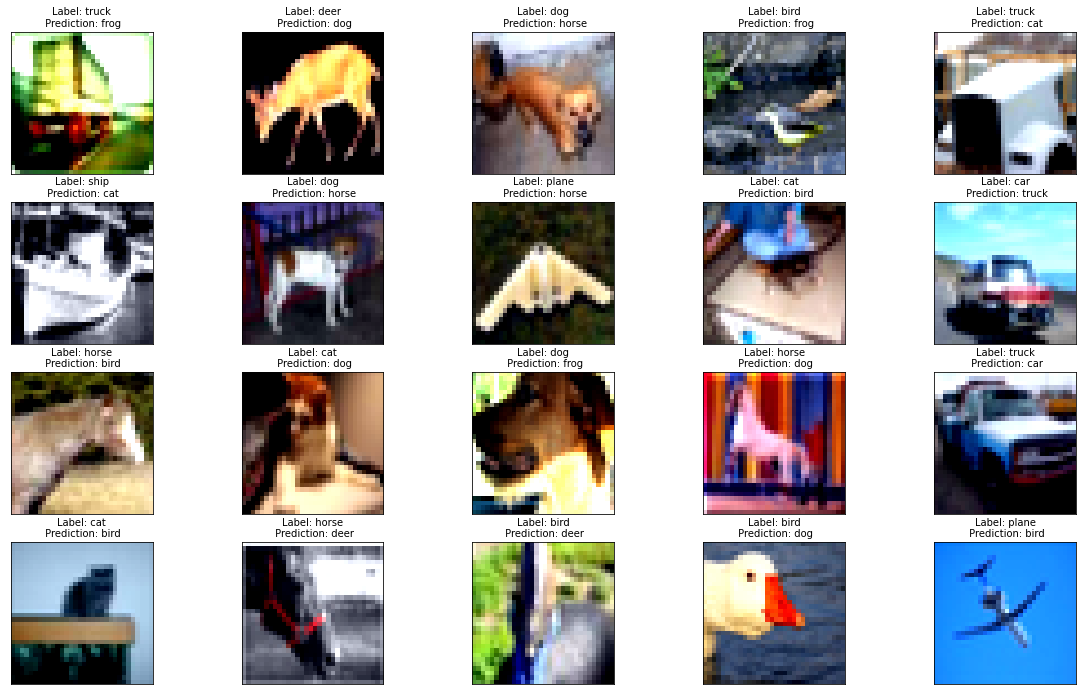

In [13]:

test_misc_images = [test_misc_images[i] for i in range(20)]
data_utils.plot_misclassified_rgb(test_misc_images, 'test_misc_batchnorm.png',plot_size=(20,12), config=modelconfig)

**GradCam**

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


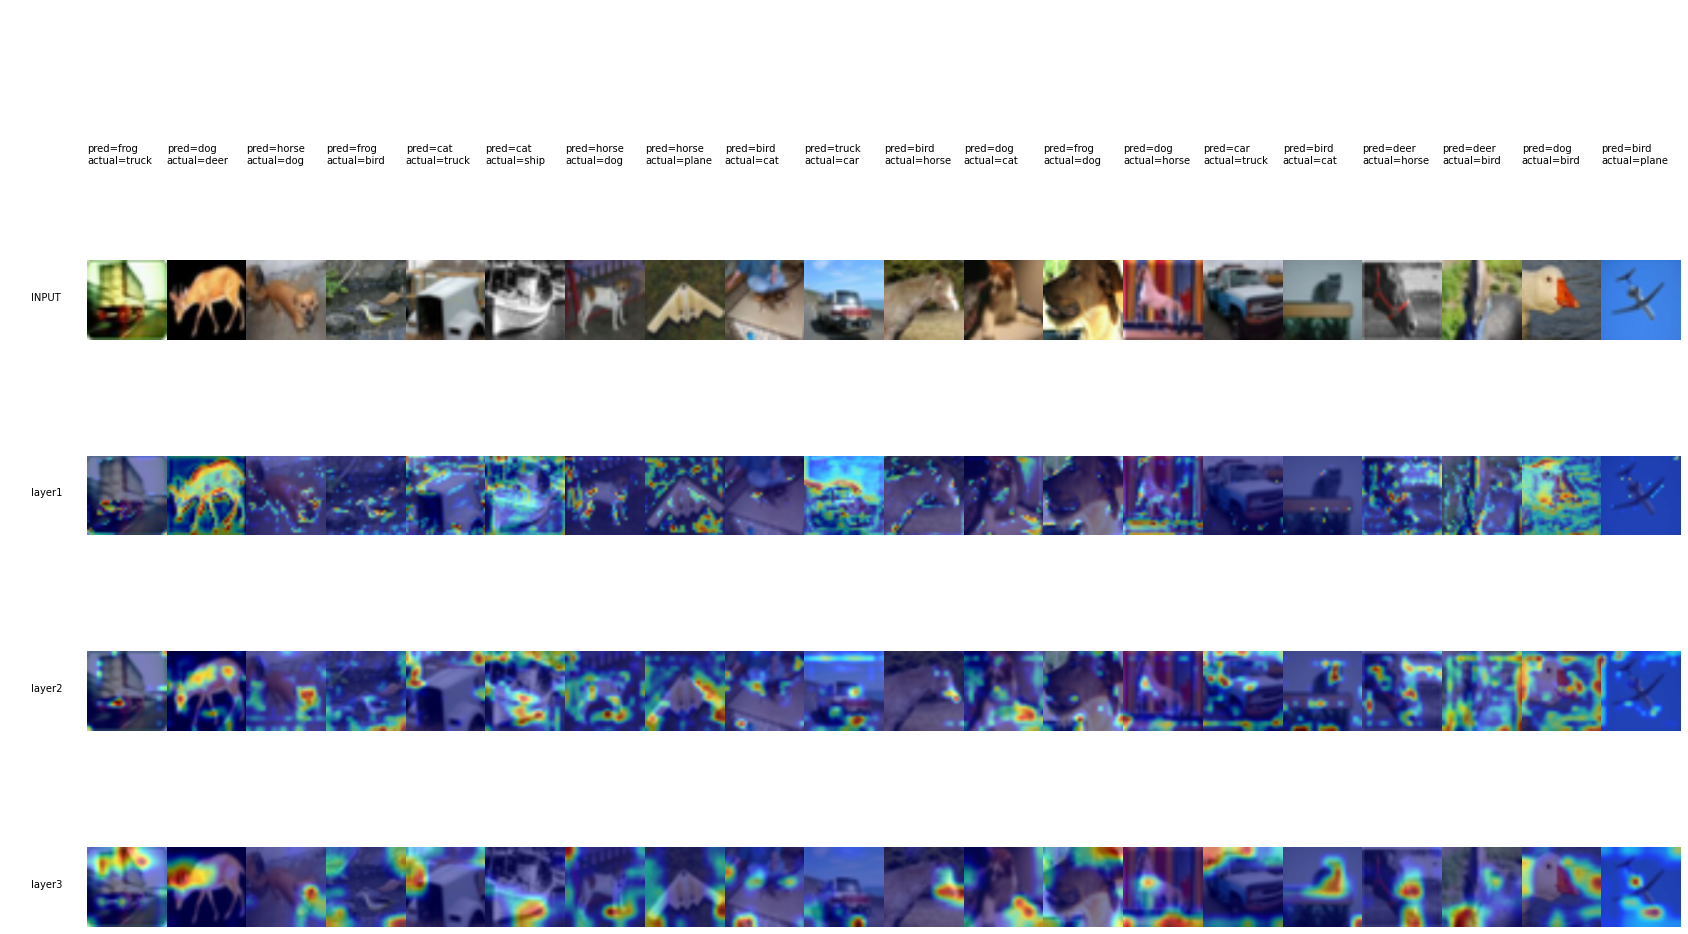

In [14]:
# model = ResNet18(mod).to(device)
image_size = (3,32,32)
device = modelconfig.device
target_layers = ["layer1", "layer2", "layer3"]#, "layer4"]

images = [x['image'] for x in test_misc_images]
target_classes = [l['label'] for l in test_misc_images]
gradcam_layers, probs, predicted_classes = generate_gcam(images, device, target_classes, model, target_layers)

plot_gcam(modelconfig, gradcam_layers, images, target_classes, target_layers, modelconfig.classes, image_size, predicted_classes)


In [15]:

get_class_accuracy(model, modelconfig)

Accuracy of plane : 72 %
Accuracy of   car : 90 %
Accuracy of  bird : 74 %
Accuracy of   cat : 74 %
Accuracy of  deer : 89 %
Accuracy of   dog : 75 %
Accuracy of  frog : 96 %
Accuracy of horse : 85 %
Accuracy of  ship : 96 %
Accuracy of truck : 79 %


In [16]:
testacc = result_dict['TestAcc']
trainacc = result_dict['TrainAcc']
testloss = result_dict['TestLoss']
trainloss = result_dict['TrainLoss']
 

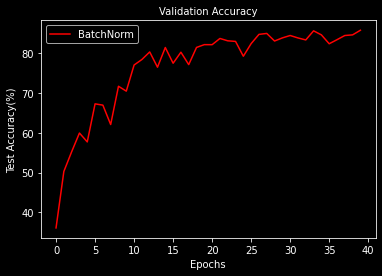

In [17]:
data_utils.plot_curve(testacc, "Test Accuracy(%)")

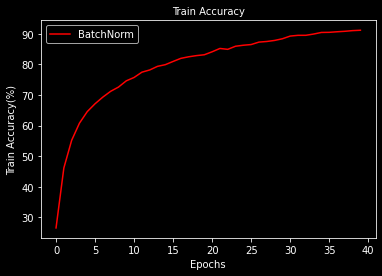

In [18]:
data_utils.plot_curve(trainacc, "Train Accuracy(%)")

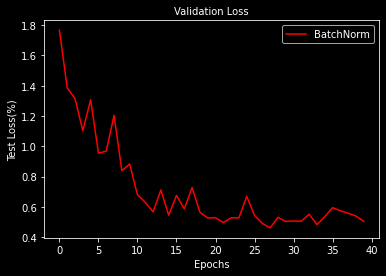

In [19]:
data_utils.plot_curve(testloss, "Test Loss(%)")

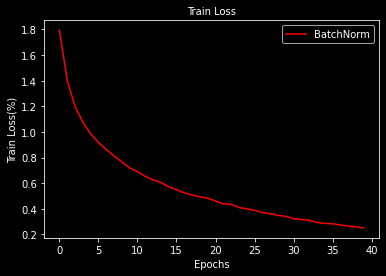

In [20]:
data_utils.plot_curve(trainloss, "Train Loss(%)")